In [77]:
import numpy as np
import awkward as ak
import uproot
import vector
import os
import mplhep as hep
import matplotlib.pyplot as plt

In [99]:
### FUNCTION DEFINITION ###
def GetMaxMjj(Jets):
    JetCombo = ak.combinations(Jets,2, fields=["jet1","jet2"])
    jjCombo  = JetCombo.jet1 + JetCombo.jet2
    mjjCombo = np.sqrt(np.abs((jjCombo.E)**2 - (jjCombo.px**2 + jjCombo.py**2 + jjCombo.pz**2)))
    maxmjj   = ak.max(mjjCombo,axis=1)
    return maxmjj

def GetMaxEta(Jets):
    JetCombo = ak.combinations(Jets,2, fields=["jet1","jet2"])
    etacombo = vector.Spatial.deltaeta(JetCombo.jet1, JetCombo.jet2)
    maxeta   = ak.max(abs(etacombo), axis=1)
    return maxeta

def ApplyJetCuts(Jets):
    ptCut = (Jets.pt>20) # looks ambiguous...leadjetpt?
    Jets = Jets[ptCut]
    
    nTracksCut = (Jets.nTracks>20)
    Jets = Jets[nTracksCut]

    return Jets

def CheatVBFJets(events):
    Jets = vector.zip({
        "pt"  : events["Jet_pt"].array(),
        "eta" : events["Jet_eta"].array(),
        "phi" : events["Jet_phi"].array(), 
        "mass": events["Jet_mass"].array(),
    })
    GenParts = vector.zip({
        "pt": events["GenPart_pt"].array(),
        "eta": events["GenPart_eta"].array(),
        "phi": events["GenPart_phi"].array(),
        "mass": events["GenPart_mass"].array(),
    })

    fromQ, IsHiggs = events["GenPart_genPartIdxMother"].array(), events["GenPart_pdgId"].array()
    nJetCut = (ak.num(Jets)>=2)
    Jets, GenParts, fromQ, IsHiggs = Jets[nJetCut], GenParts[nJetCut], fromQ[nJetCut], IsHiggs[nJetCut]
    IsMotherProton = (fromQ==0) & (IsHiggs!=25)
    MotherProton = GenParts[IsMotherProton]
    JetMomCombo = ak.cartesian({"mom": MotherProton,"jet": Jets})
    dR = vector.Spatial.deltaR(JetMomCombo.mom, JetMomCombo.jet)
    min_dR = ak.where((dR-ak.sort(dR)[:,1])<0.0001, True, False)
    VBFJets = JetMomCombo.jet[min_dR]

    return VBFJets

In [131]:
sigDict = {
    "name": "sig",
    "filenames": [x for x in os.listdir(sigPath) if x != '.DS_Store'],  # change this for remote desktop!! #"filenames": os.listdir(sigPath)[:2]
    "path": "/Users/raymondkil/Desktop/VBF Trigger/shaperootfiles/Signal/", # change this for remote desktop!!
    "doAnalysis": True,
    "maxmjjs": [],
    "maxetas": [],
    "VBFmjjs": [],
    "VBFetas": [],
    "plotcolor": "tab:blue",
}

ewkDict = {
    "name": "ewk",
    "filenames": [x for x in os.listdir(ewkPath) if x != '.DS_Store'],
    "path": "/Users/raymondkil/Desktop/VBF Trigger/shaperootfiles/EWKW/",
    "doAnalysis": True,
    "maxmjjs": [],
    "maxetas": [],
    "VBFmjjs": [],
    "VBFetas": [],
    "plotcolor": "tab:orange",
}

qcdDict = {
    "name": "qcd",
    "filenames": [x for x in os.listdir(qcdPath) if x != '.DS_Store'],
    "path": "/Users/raymondkil/Desktop/VBF Trigger/shaperootfiles/QCDInclusive/",
    "doAnalysis": True,
    "maxmjjs": [],
    "maxetas": [],
    "VBFmjjs": [],
    "VBFetas": [],
    "plotcolor": "tab:green",
}

processes = [sigDict, ewkDict, qcdDict]

for process in processes: 
    if process["doAnalysis"]: 
        print("Starting {} analysis!".format(process["name"]))
        for filename in process["filenames"]:
            print("processing file {}".format(filename))
            f      = uproot.open(process["path"]+filename)
            events = f["Events"]

            Jets = vector.zip({
                "pt"  : events["Jet_pt"].array(),
                "eta" : events["Jet_eta"].array(),
                "phi" : events["Jet_phi"].array(), 
                "mass": events["Jet_mass"].array(),
                "nTracks": events["Jet_nConstituents"].array(),
                "genWeight": events["genWeight"].array()
            })
            nJetCut = (ak.num(Jets)>=2)
            Jets = Jets[nJetCut]
            #Jets = ApplyJetCuts(Jets)

            process["maxmjjs"] = np.concatenate((process["maxmjjs"], GetMaxMjj(Jets)))
            process["maxetas"] = np.concatenate((process["maxetas"], GetMaxEta(Jets)))

            VBFJet1, VBFJet2 = CheatVBFJets(events)[:,0], CheatVBFJets(events)[:,1]
            VBFjjCombo  = VBFJet1 + VBFJet2
            VBFmjj = np.sqrt(np.abs((VBFjjCombo.E)**2 - (VBFjjCombo.px**2 + VBFjjCombo.py**2 + VBFjjCombo.pz**2)))
            VBFeta = vector.Spatial.deltaeta(VBFJet1, VBFJet2)

            process["VBFmjjs"] = np.concatenate((process["VBFmjjs"], VBFmjj))
            process["VBFetas"] = np.concatenate((process["VBFetas"], VBFeta))
    print("\n")

Starting sig analysis!
processing file nanoaod_1001.root
processing file nanoaod_1002.root


Starting ewk analysis!
processing file 2F207CF9-3260-064E-863D-4A7B37D78170.root
processing file 9838C452-2938-5F43-96B4-5641BA9204B2.root


Starting qcd analysis!
processing file 98C81B52-073F-5843-B931-694099AC3850.root
processing file 0ED70AAD-357D-6646-985A-87C201AB6CD8.root




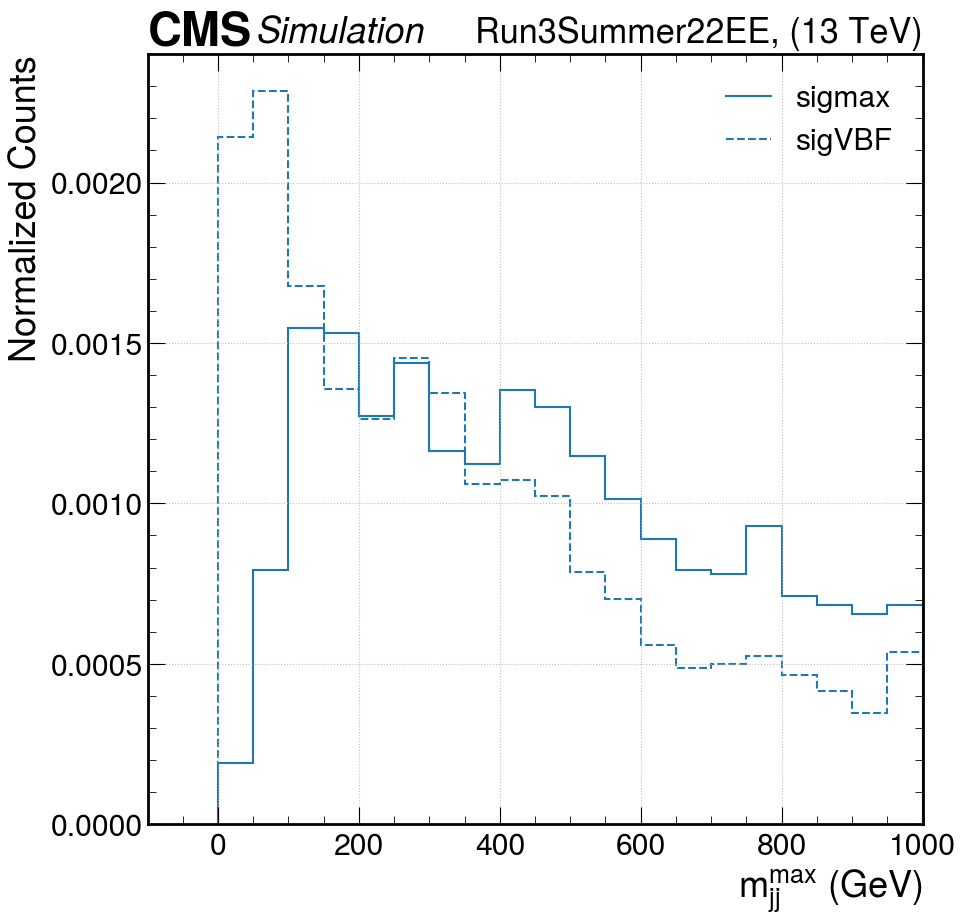

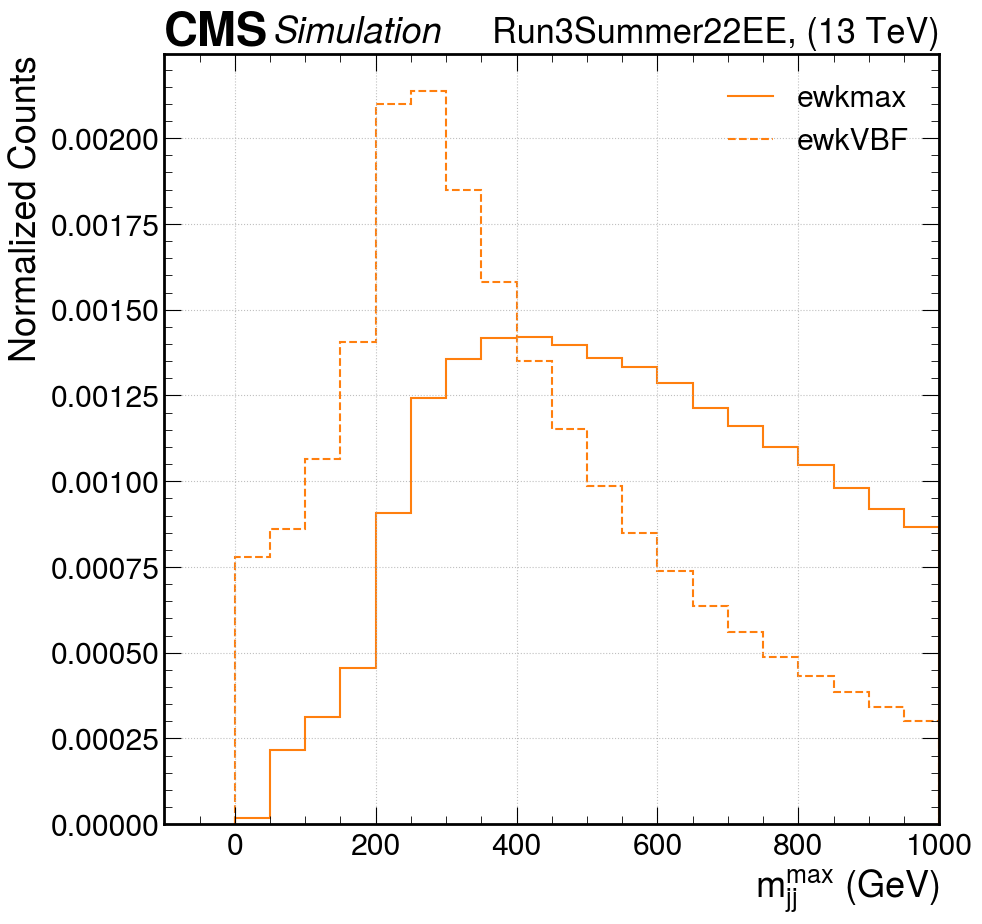

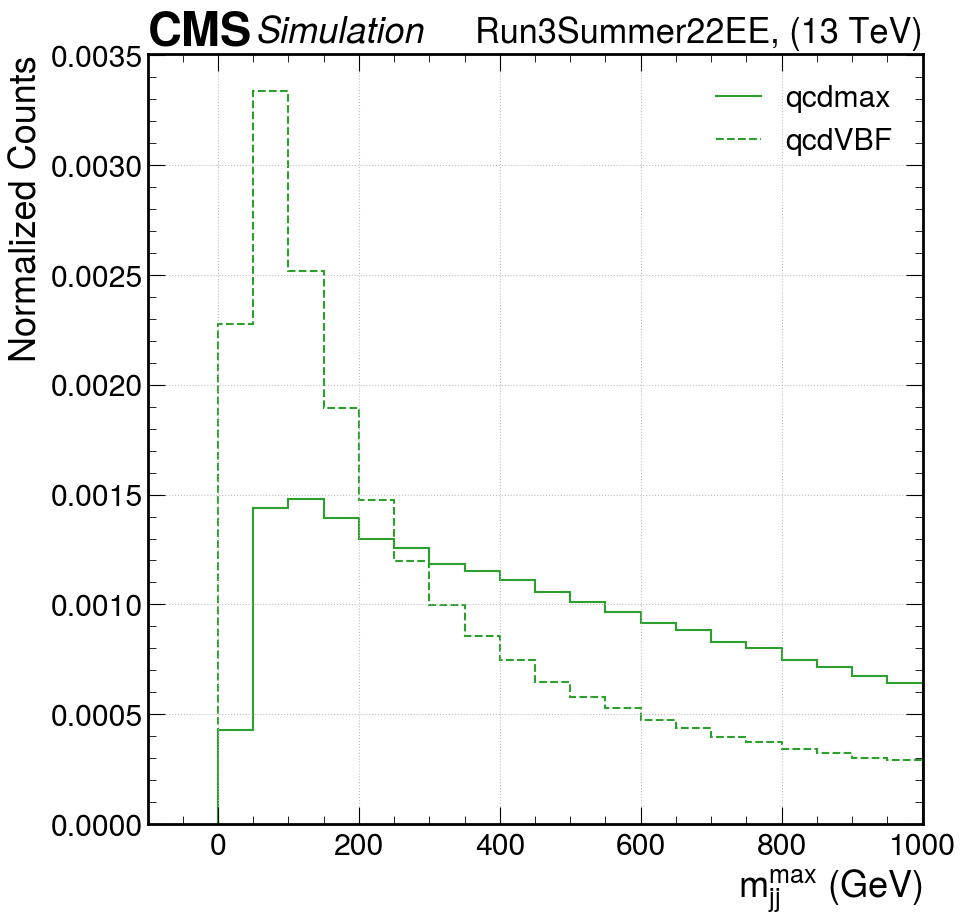

In [138]:
#pltPath = "/eos/user/j/jkil/www/VBFSUEP/shapeAnalysis/"
xlim = 1000
binsize = 50

plt.style.use(hep.style.CMS)
for process in processes:
    plt.figure()
    if process["doAnalysis"]: 
        maxmjjs, VBFmjjs = process["maxmjjs"], process["VBFmjjs"]
        maxhist, maxbins = np.histogram(maxmjjs, bins=np.arange(0,xlim+binsize,binsize))
        VBFhist, VBFbins = np.histogram(VBFmjjs, bins=np.arange(0,xlim+binsize,binsize))
        hep.histplot(maxhist, maxbins, histtype='step', label=process["name"]+"max", color=process["plotcolor"], density=True, stack=True)
        hep.histplot(VBFhist, VBFbins, histtype='step', label=process["name"]+"VBF", color=process["plotcolor"], density=True, stack=True, linestyle='--')

    hep.cms.text("Simulation")
    hep.cms.lumitext(r"Run3Summer22EE, (13 TeV)")
    plt.xlabel(r"$m_{jj}^{max}$ (GeV)")
    plt.ylabel(r"Normalized Counts")
    plt.xlim(-100,xlim)
    plt.legend()
    plt.grid()
#plt.savefig("{}shape.png".format(pltPath))

# I should get dotted lines and solid lines to behave similar. That would mean that selecting max values are actually selecting vbf values.
# On the other hand, if I do the same thing to QCD, it should behave poorly, because there is no VBF jet in QCD!

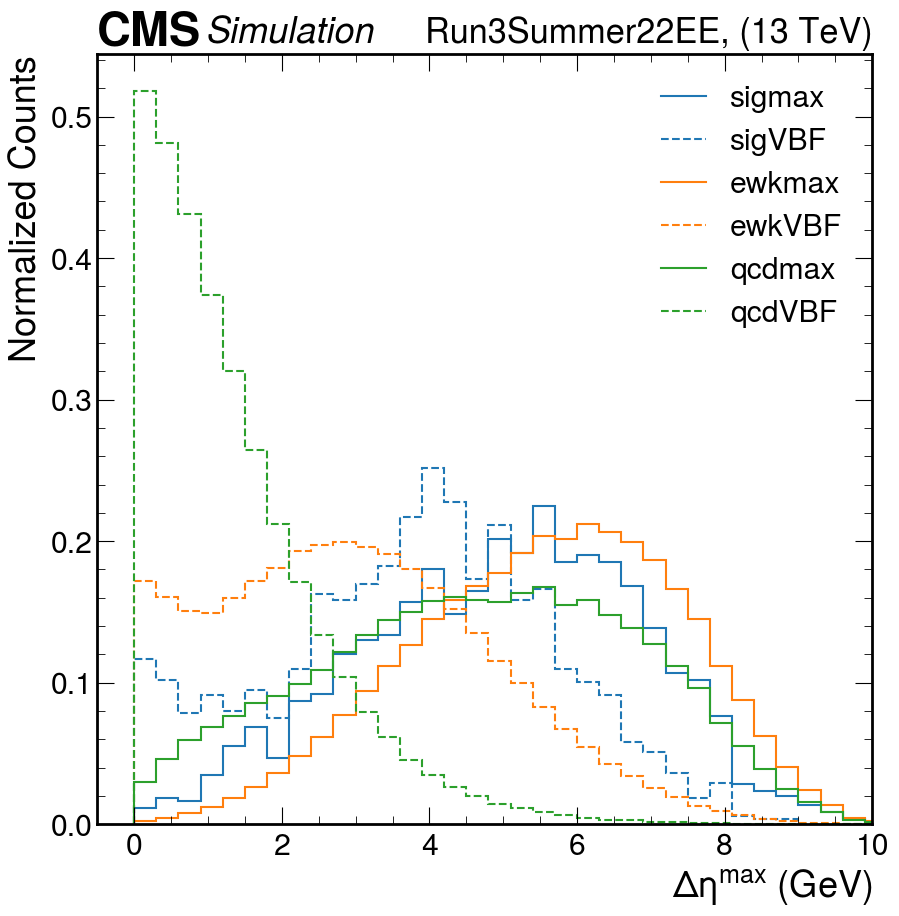

In [136]:
#pltPath = "/eos/user/j/jkil/www/VBFSUEP/shapeAnalysis/"
xlim = 10
binsize = 0.3

plt.figure()
plt.style.use(hep.style.CMS)
for process in processes: 
    if process["doAnalysis"]: 
        maxetas, VBFetas = process["maxetas"], process["VBFetas"]
        maxhist, maxbins = np.histogram(maxetas, bins=np.arange(0,xlim+binsize,binsize))
        VBFhist, VBFbins = np.histogram(VBFetas, bins=np.arange(0,xlim+binsize,binsize))
        hep.histplot(maxhist, maxbins, histtype='step', label=process["name"]+"max", color=process["plotcolor"], density=True, stack=True)
        hep.histplot(VBFhist, VBFbins, histtype='step', label=process["name"]+"VBF", color=process["plotcolor"], density=True, stack=True, linestyle='--')

hep.cms.text("Simulation")
hep.cms.lumitext(r"Run3Summer22EE, (13 TeV)")
plt.xlabel(r"$\Delta\eta^{max}$ (GeV)")
plt.ylabel(r"Normalized Counts")
plt.xlim(-0.5,xlim)
plt.legend()
#plt.savefig("{}shape.png".format(pltPath))

In [ ]:
# Should run this in remote desktop with all the files.
# Should do the VBF tagged analysis. (cheating method)